In [1]:
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
import pandas as pd
from tqdm import tqdm

import importlib
import foraging_choice as fc
from foraging_choice import compute_foraging_choice

from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_behavior_gym.dynamic_foraging.agent.random_agent import RandomAgent, RandomAgentBiasedIgnore
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency

importlib.reload(fc)
print(dir(fc))


['ForagingSessionData', 'List', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_block_transitions_and_stats', 'compute_foraging_choice', 'np', 'pd']


##### Testing Foraging Choice Metric #####

In [2]:

def get_history_from_nwb(nwb_file):
    """Get choice and reward history from nwb file"""

    io = NWBHDF5IO(nwb_file, mode="r")
    nwb = io.read()
    df_trial = nwb.trials.to_dataframe()

    autowater_offered = (df_trial.auto_waterL == 1) | (df_trial.auto_waterR == 1)
    choice_history = df_trial.animal_response.map({0: 0, 1: 1, 2: np.nan}).values
    reward_history = df_trial.rewarded_historyL | df_trial.rewarded_historyR
    p_reward = [
        df_trial.reward_probabilityL.values,
        df_trial.reward_probabilityR.values,
    ]
    random_number = [
        df_trial.reward_random_number_left.values,
        df_trial.reward_random_number_right.values,
    ]

    baiting = False if "without baiting" in nwb.protocol.lower() else True

    return (
        baiting,
        choice_history,
        reward_history,
        p_reward,
        autowater_offered,
        random_number,
    )

In [3]:
working_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/769887_2024-11-04_09-24-25.nwb'

In [4]:
file_path = working_file
baiting, choice_history, reward_history, p_reward, autowater_offered, random_number = get_history_from_nwb(working_file)

In [5]:
# Print types for all variables

# Print stats for choice_history
print("\nChoice History Stats:")
print(f"Type: {type(choice_history)}")
print(f"Length: {len(choice_history)}")
print(f"Dtype: {choice_history.dtype}")
print(f"Number of unique values: {len(np.unique(choice_history[~np.isnan(choice_history)]))}")
print(f"Missing values: {np.sum(np.isnan(choice_history))}")
print(f"Mean: {np.nanmean(choice_history)}")
print(f"Std: {np.nanstd(choice_history)}")
print(f"Min: {np.nanmin(choice_history)}")
print(f"Max: {np.nanmax(choice_history)}")

# Print stats for reward_history
print("\nReward History Stats:")
print(f"Type: {type(reward_history)}")
print(f"Length: {len(reward_history)}")
print(f"Dtype: {reward_history.dtype}")
print(f"Number of unique values: {reward_history.nunique()}")
print(f"Missing values: {reward_history.isna().sum()}")
print(f"True count: {reward_history.sum()}")
print(f"False count: {(~reward_history).sum()}")

# Print stats for p_reward
print("\nP Reward Stats:")
print(f"Type: {type(p_reward)}")
print("Left Side:")
print(f"Length: {len(p_reward[0])}")
print(f"Dtype: {p_reward[0].dtype}")
print(f"Number of unique values: {len(np.unique(p_reward[0]))}")
print(f"Missing values: {np.sum(np.isnan(p_reward[0]))}")
print(f"Mean: {np.mean(p_reward[0])}")
print(f"Std: {np.std(p_reward[0])}")
print(f"Min: {np.min(p_reward[0])}")
print(f"Max: {np.max(p_reward[0])}")
print("\nRight Side:")
print(f"Length: {len(p_reward[1])}")
print(f"Dtype: {p_reward[1].dtype}")
print(f"Number of unique values: {len(np.unique(p_reward[1]))}")
print(f"Missing values: {np.sum(np.isnan(p_reward[1]))}")
print(f"Mean: {np.mean(p_reward[1])}")
print(f"Std: {np.std(p_reward[1])}")
print(f"Min: {np.min(p_reward[1])}")
print(f"Max: {np.max(p_reward[1])}")

# Print stats for autowater_offered
print("\nAutowater Offered Stats:")
print(f"Type: {type(autowater_offered)}")
print(f"Length: {len(autowater_offered)}")
print(f"Dtype: {autowater_offered.dtype}")
print(f"Number of unique values: {autowater_offered.nunique()}")
print(f"Missing values: {autowater_offered.isna().sum()}")
print(f"True count: {autowater_offered.sum()}")
print(f"False count: {(~autowater_offered).sum()}")



Choice History Stats:
Type: <class 'numpy.ndarray'>
Length: 594
Dtype: float64
Number of unique values: 2
Missing values: 252
Mean: 0.4152046783625731
Std: 0.49275729667698
Min: 0.0
Max: 1.0

Reward History Stats:
Type: <class 'pandas.core.series.Series'>
Length: 594
Dtype: bool
Number of unique values: 2
Missing values: 0
True count: 59
False count: 535

P Reward Stats:
Type: <class 'list'>
Left Side:
Length: 594
Dtype: float64
Number of unique values: 3
Missing values: 0
Mean: 0.2956228956228957
Std: 0.39731552805806597
Min: 0.0
Max: 1.0

Right Side:
Length: 594
Dtype: float64
Number of unique values: 3
Missing values: 0
Mean: 0.5215488215488214
Std: 0.39197371391153407
Min: 0.0
Max: 1.0

Autowater Offered Stats:
Type: <class 'pandas.core.series.Series'>
Length: 594
Dtype: bool
Number of unique values: 2
Missing values: 0
True count: 186
False count: 408


In [6]:
import importlib
importlib.reload(fc)
print(dir(fc))

['ForagingSessionData', 'List', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_block_transitions_and_stats', 'compute_foraging_choice', 'np', 'pd']


In [7]:
local_metric, global_metric = compute_foraging_choice(choice_history, 
                                          reward_history, 
                                          p_reward, 
                                          autowater_offered,
                                          global_calc=None)  # Set to None to get both metrics

print(f'global_metric: {global_metric}')
print(f'local_metric: {local_metric}')

global_metric: 0.3106060606060606
local_metric: 0.8237460397692911


##### Testing Custom Task Environments #####

In [8]:
# Starting with Coupled Baiting Block Task

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Base off streamlit or bonsai data?

task_stage_1 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 20,
    block_beta = 5,
    p_reward_pairs = [
        [0.8, 0]
    ],
    seed=42
)

task_stage_2 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 40,
    block_beta = 10,
    p_reward_pairs = [
        [0.55, 0.05]
    ],
    seed=42
)

task_stage_3 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 300,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05]
    ],
    seed=42
)

task_stage_final = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 400,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

task_stage_graduated = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 450,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

In [9]:
df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_67023/3477088254.py:1: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv')


In [10]:
# Checking values 

print("Rows matching STAGE_1:", len(df[df['auto_train_stage'] == 'STAGE_1']))
print("Rows matching Coupled Baiting:", len(df[df['auto_train_curriculum_name'] == 'Coupled Baiting']))
print("Rows matching version 2.3:", len(df[df['auto_train_curriculum_version'] == '2.3']))

df_test = df[
    (df['auto_train_stage'] == 'STAGE_FINAL') &
    (df['auto_train_curriculum_name'] == 'Coupled Baiting') &
    (df['auto_train_curriculum_version'] == '2.2')
]

print("\nTotal rows after modified filtering:", len(df_test))

Rows matching STAGE_1: 105337
Rows matching Coupled Baiting: 149055
Rows matching version 2.3: 697522

Total rows after modified filtering: 29501


In [11]:
df

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval
0,0,2.0,False,False,False,False,0.45,0.4,0.05,0.789076,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
1,1,2.0,False,False,False,False,0.45,0.4,0.05,0.518192,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
2,2,0.0,True,False,True,False,0.45,0.4,0.05,0.367511,...,16.160096,0.487072,16.153088,0.480064,True,False,687553,2023-12-01,NaN,NaN
3,3,0.0,True,False,True,False,0.45,0.4,0.05,0.053372,...,25.333088,0.376064,25.331872,0.374848,True,False,687553,2023-12-01,NaN,NaN
4,4,0.0,False,False,False,False,0.45,0.4,0.05,0.955191,...,NaN,NaN,34.364160,0.157440,False,False,687553,2023-12-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577768,582,1.0,False,False,False,False,0.45,0.4,0.05,0.700221,...,NaN,NaN,5378.042624,0.199680,False,False,724555,2024-07-10,0.0,0.0
2577769,583,2.0,False,False,False,False,0.45,0.4,0.05,0.678467,...,NaN,NaN,NaN,NaN,False,False,724555,2024-07-10,0.0,0.0
2577770,584,1.0,False,False,True,False,0.45,0.4,0.05,0.050451,...,NaN,NaN,5392.707232,0.347424,False,False,724555,2024-07-10,0.0,0.0
2577771,585,1.0,False,False,True,False,0.45,0.4,0.05,0.118763,...,NaN,NaN,5404.919264,0.359232,False,False,724555,2024-07-10,0.0,0.0


##### Testing Agent in Task Environments #####

In [12]:
# Test agent on all task environments 

def run_task_env(task, stage_name, n_sims=100, seed_start=42):
    """
    Run n simulations for each stage task and get foraging choice values
    """ 
    results = []

    for sim in tqdm(range(n_sims), desc=f'Running {n_sims} simulations'):
        # Create forager for each sim
        forager_collection = ForagerCollection()
        forager = forager_collection.get_preset_forager('Hattori2019', seed=seed_start+sim)
        forager.set_params(softmax_inverse_temperature=5, biasL=0)

        # Set new seed for task 
        task.seed = seed_start + sim
        # Run sim
        forager.perform(task)

        # Calculate metrics
        foraging_eff, eff_random_seed = compute_foraging_efficiency(
            baited=task.reward_baiting,
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            random_number=task.random_numbers.T,
        )
        
        foraging_choice_local, foraging_choice_global = compute_foraging_choice(
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            global_calc=None
        )
        
        results.append({
            'stage': stage_name,
            'simulation': sim,
            'foraging_efficiency': foraging_eff,
            'foraging_efficiency_random_seed': eff_random_seed,
            'foraging_choice_local': foraging_choice_local,
            'foraging_choice_global': foraging_choice_global,
            'random_seed': seed_start + sim,
            'num_trials': task.num_trials,
            'block_min': task.block_min,
            'block_max': task.block_max,
            'block_beta': task.block_beta,
        })
    
    return pd.DataFrame(results)

In [13]:
# Create dictionary of task environments

tasks = {
    'STAGE_1': task_stage_1,
    'STAGE_2': task_stage_2,
    'STAGE_3': task_stage_3,
    'STAGE_FINAL': task_stage_final,
    'STAGE_GRADUATED': task_stage_graduated
}

# Set function args
n_sims = 1000
seed_start = 42

# Run simulations
all_results = []

for stage_name, task in tasks.items():
    print(f'\nRunning {stage_name} task...')
    results_df = run_task_env(task, stage_name, n_sims=n_sims)
    all_results.append(results_df)

combined_results = pd.concat(all_results, ignore_index=True)


Running STAGE_1 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:09<00:00, 107.69it/s]



Running STAGE_2 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:09<00:00, 109.82it/s]



Running STAGE_3 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:12<00:00, 78.02it/s]



Running STAGE_FINAL task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:16<00:00, 60.99it/s]



Running STAGE_GRADUATED task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:18<00:00, 54.49it/s]


In [14]:
# Create a summary DataFrame grouped by stage and task_type
summary_stats = combined_results.groupby(['stage']).agg({
    'foraging_efficiency': 'mean',
    'foraging_choice_local': 'mean', 
    'foraging_choice_global': 'mean',
    'num_trials': 'mean',
    'block_min': 'mean',
    'block_max': 'mean',
    'block_beta': 'mean'
}).round(4)

In [15]:
summary_stats

,foraging_efficiency,foraging_choice_local,foraging_choice_global,num_trials,block_min,block_max,block_beta
stage,,,,,,,
STAGE_1,0.5110,-0.0798,-0.0272,200.0,10.0,20.0,5.0
STAGE_2,0.6426,0.0182,0.1248,200.0,10.0,40.0,10.0
STAGE_3,0.7723,0.2876,0.3758,300.0,20.0,60.0,20.0
STAGE_FINAL,0.7477,0.1595,0.1933,400.0,20.0,60.0,20.0
STAGE_GRADUATED,0.7478,0.1591,0.1913,450.0,20.0,60.0,20.0


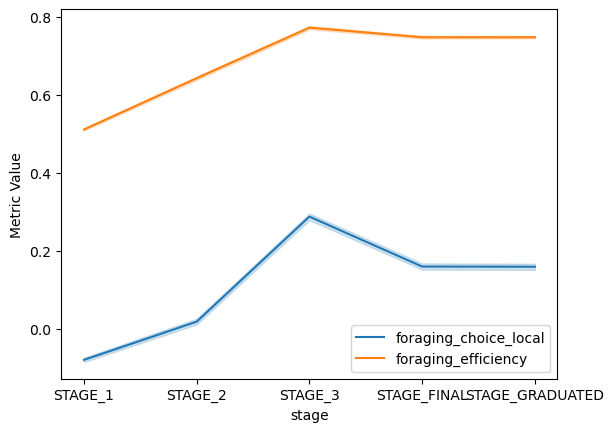

In [17]:
sns.lineplot(combined_results, x='stage', y='foraging_choice_local', label='foraging_choice_local')
sns.lineplot(combined_results, x='stage', y='foraging_efficiency', label='foraging_efficiency')
plt.ylabel('Metric Value')
plt.show()
